# Traing Models target 1: Livello_Acqua

## Libreries set up

In [1]:
!pip install  pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 31.5 MB/s 
     |████████████████████████████████| 9.8 MB 33.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [2]:
#!pip install -U matplotlib

In [3]:
!pip install scikit-learn==1.0.2 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [5]:
from pmdarima import auto_arima
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.stattools import durbin_watson
import matplotlib as mpl
%matplotlib inline
from statsmodels.tools.eval_measures import mse,rmse
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels as stats
import pickle

In [6]:
from xgboost import XGBRegressor , plot_importance, plot_tree
from sklearn.model_selection import TimeSeriesSplit , GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFECV
import warnings

In [7]:
seed = np.random.seed(22)
rng = np.random.RandomState(1)

##Utils

In [8]:
def to_list(values):
    list=[]
    for val in values:
        for v in val:
            list.append(v)
    return(list)

##1) SARIMAX 

In [ ]:
sar_train_data = pd.read_csv('/content/gdrive/MyDrive/Progetto_industry/Data/Prepared/train_sarima.csv')
sar_train_data['Data'] = pd.to_datetime(sar_train_data['Data'], format="%Y-%m-%d")
sar_train_data.set_index('Data', inplace=True)

In [ ]:
sar_train_data.shape

(6013, 1)

In [ ]:
auto=auto_arima(sar_train_data)

In [ ]:
auto.set_params

<bound method BaseEstimator.set_params of ARIMA(order=(2, 1, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)>

Train SARIMA model for 'Livello Acqua w/o exogeneous variables


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                        Livello_Acqua   No. Observations:                 6013
Model:             SARIMAX(1, 1, 4)x(0, 0, [1], 24)   Log Likelihood                5827.035
Date:                              Tue, 12 Jul 2022   AIC                         -11640.070
Time:                                      09:27:06   BIC                         -11593.159
Sample:                                  01-06-2003   HQIC                        -11623.781
                                       - 06-23-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9662      0.008    118.406      0.000       0.950       0.982
ma.L1         -0.61

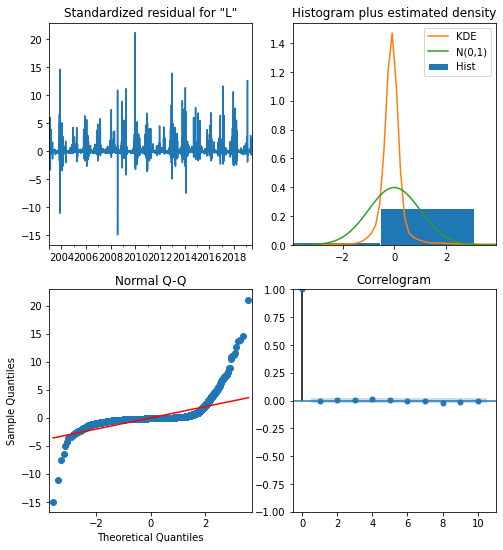


Diagnostics plots look almost normal
Irregularities might be due to the outliers


In [ ]:
print(f"Train SARIMA model for 'Livello Acqua w/o exogeneous variables")

p_LT2 = 2
d_LT2 = 1
q_LT2 = 3
P_LT2 = 0
D_LT2 = 0
Q_LT2 = 1
s_LT2 = 24

model_SARIMA = SARIMAX(sar_train_data, 
                       order=(p_LT2, d_LT2, q_LT2),
                       seasonal_order=(P_LT2, D_LT2, Q_LT2, s_LT2),
                       enforce_invertibility=False)

model_SARIMA_fit = model_SARIMA.fit(disp=0)
print(model_SARIMA_fit.summary())
print('')

print('Each term in the model is significant, P>|z| is less than 0.05')


model_SARIMA_fit.plot_diagnostics(figsize=(8,9))
plt.show();

print('')
print("Diagnostics plots look almost normal")
print("Irregularities might be due to the outliers")



In [ ]:
from statsmodels.stats.stattools import durbin_watson

#perform Durbin-Watson test
durbin_watson(model_SARIMA_fit.resid)

# The test statistic is 2.392. Since this is within the range of 1.5 and 2.5, 
# we would consider autocorrelation not to be problematic in this regression model.

1.0509174476866905

In [ ]:
filename = '/content/gdrive/MyDrive/Progetto_industry/Models/model_arima.pkl'
model_SARIMA_fit.save(filename, remove_data=False)

##2) XGBoost

In [ ]:
xgb_train_data = pd.read_csv('/content/gdrive/MyDrive/Progetto_industry/Data/Prepared/train_SL.csv').drop('Unnamed: 0', axis=1)
xgb_train_data['Data'] = pd.to_datetime(xgb_train_data['Data'], format="%Y-%m-%d")
xgb_train_data.set_index('Data', inplace=True)
X = xgb_train_data.drop(['Target'],axis=1)
y = xgb_train_data['Target']

### 2.1) GridSerachCV

In [ ]:
tscv = TimeSeriesSplit(n_splits=10)
gsc = GridSearchCV(
            estimator=XGBRegressor(),
            param_grid={'objective' :['reg:squarederror'],
                        "learning_rate": (0.5,0.001 ,0.05, 0.15),
                        'n_estimators': [150,200],
                        'subsample': [0.7,0.9],
                        "max_depth": [ 2,3, 4],
                        "min_child_weight": [ 5, 7,10],
                        "gamma":[ 0.01, 0.1, 0.2],
                        "colsample_bytree":[ 0.3, 0.4],
                         "booster" : ['gbtree','gblinear'],
                        'random_state':[123],
                        'seed': [456]},
            cv=tscv, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1,)



In [ ]:
gsc.fit(X,y)

Fitting 10 folds for each of 1728 candidates, totalling 17280 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=XGBRegressor(), n_jobs=-1,
             param_grid={'booster': ['gbtree', 'gblinear'],
                         'colsample_bytree': [0.3, 0.4],
                         'gamma': [0.01, 0.1, 0.2],
                         'learning_rate': (0.5, 0.001, 0.05, 0.15),
                         'max_depth': [2, 3, 4], 'min_child_weight': [5, 7, 10],
                         'n_estimators': [150, 200],
                         'objective': ['reg:squarederror'],
                         'random_state': [123], 'seed': [456],
                         'subsample': [0.7, 0.9]},
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
gsc.best_params_

{'booster': 'gbtree',
 'colsample_bytree': 0.4,
 'gamma': 0.2,
 'learning_rate': 0.05,
 'max_depth': 2,
 'min_child_weight': 10,
 'n_estimators': 200,
 'objective': 'reg:squarederror',
 'random_state': 123,
 'seed': 456,
 'subsample': 0.7}

###2.2) Feature Selection&Importance

In [ ]:
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFECV
import warnings
warnings.filterwarnings('ignore')

In [ ]:
params=gsc.best_params_

<BarContainer object of 24 artists>

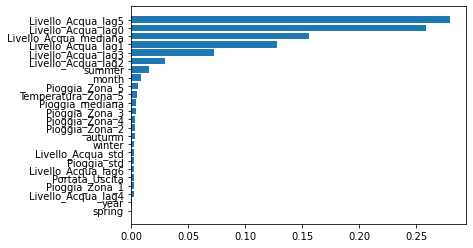

In [ ]:
model = XGBRegressor(**params)
model_fit = model.fit(X, y)
sorted_idx = model_fit.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], model_fit.feature_importances_[sorted_idx])

In [ ]:
estimator = XGBRegressor(**params)

In [ ]:
selector = RFECV(estimator, cv=tscv, scoring='neg_mean_squared_error')
selector = selector.fit(X, y)

In [ ]:
selector.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [ ]:
selector.n_features_

24

In [ ]:
selector.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

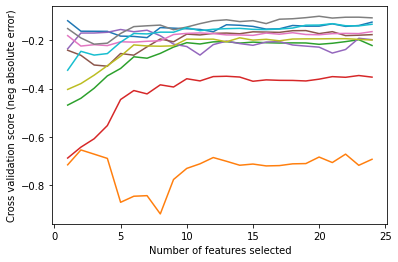

In [ ]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (neg absolute error)")
plt.plot(
    range(1, len(selector.grid_scores_) + 1),
    selector.grid_scores_,
)
plt.show();

###2.3) Tarining and Saving

In [ ]:
model = XGBRegressor(**params)
model_fit = model.fit(X, y)

In [ ]:
filename = '/content/gdrive/MyDrive/Progetto_industry/Models/XGB_model_LA.sav'
pickle.dump(model, open(filename, 'wb'))

##3) Random Forest

In [ ]:
xgb_train_data = pd.read_csv('/content/gdrive/MyDrive/Progetto_industry/Data/Prepared/train_SL.csv').drop('Unnamed: 0', axis=1)
xgb_train_data['Data'] = pd.to_datetime(xgb_train_data['Data'], format="%Y-%m-%d")
xgb_train_data.set_index('Data', inplace=True)
X = xgb_train_data.drop(['Target'],axis=1)
y = xgb_train_data['Target']

### 3.1) GridSerachCV

In [ ]:
estimator = RandomForestRegressor()
param_grid = { 
        "criterion":["squared_error", "absolute_error"],
        "n_estimators": [30,50,100],
        "max_features": ["auto"],
        "min_samples_split" : [2,4,8],
        "max_depth": [9,10],
        "min_samples_leaf":[2,3,4],
        'random_state' : [rng]
        }
  

In [ ]:
rsc = GridSearchCV(
            estimator=estimator,
            param_grid=param_grid,
            cv=tscv, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

In [ ]:
rsc.fit(X,y)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'absolute_error'],
                         'max_depth': [9, 10], 'max_features': ['auto'],
                         'min_samples_leaf': [2, 3, 4],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [30, 50, 100],
                         'random_state': [RandomState(MT19937) at 0x7F05209D0C00]},
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
rsc.best_params_

{'criterion': 'absolute_error',
 'max_depth': 9,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 100,
 'random_state': RandomState(MT19937) at 0x7F05209D0C00}

###3.2) Feature Selection&Importance

In [ ]:
params=rsc.best_params_

<BarContainer object of 24 artists>

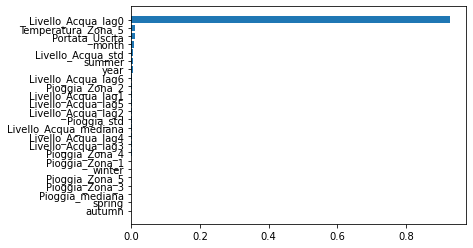

In [ ]:
model = RandomForestRegressor(**params)
model_fit = model.fit(X, y)
sorted_idx = model_fit.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], model_fit.feature_importances_[sorted_idx])

In [ ]:
estimator = RandomForestRegressor(**params)

In [ ]:
selector = RFECV(estimator, step=1, cv=tscv, scoring='neg_mean_squared_error')
selector = selector.fit(X, y)

In [ ]:
selector.ranking_

array([14,  5, 17, 10, 20,  1,  1, 21, 19,  4, 16,  1,  6, 18, 12,  1,  8,
       11, 15, 13,  9,  7,  3,  2])

In [ ]:
selector.n_features_

4

In [ ]:
selector.support_

array([False, False, False, False, False,  True,  True, False, False,
       False, False,  True, False, False, False,  True, False, False,
       False, False, False, False, False, False])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


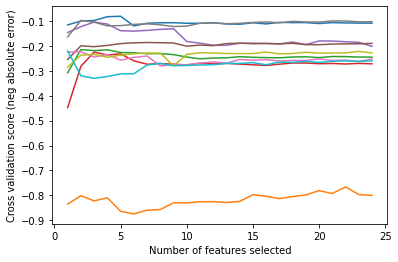

In [ ]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (neg absolute error)")
plt.plot(
    range(1, len(selector.grid_scores_) + 1),
    selector.grid_scores_,
)
plt.show();

###3.3) Tarining and Saving

In [ ]:
model = RandomForestRegressor(**params)
model_fit = model.fit(X, y)

In [ ]:
filename = '/content/gdrive/MyDrive/Progetto_industry/Models/RF_model_LA.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
X.columns

Index(['Pioggia_Zona_1', 'Pioggia_Zona_2', 'Pioggia_Zona_3', 'Pioggia_Zona_4',
       'Pioggia_Zona_5', 'Temperatura_Zona_5', 'Portata_Uscita', 'autumn',
       'spring', 'summer', 'winter', 'month', 'year', 'Pioggia_mediana',
       'Pioggia_std', 'Livello_Acqua_lag0', 'Livello_Acqua_lag1',
       'Livello_Acqua_lag2', 'Livello_Acqua_lag3', 'Livello_Acqua_lag4',
       'Livello_Acqua_lag5', 'Livello_Acqua_lag6', 'Livello_Acqua_mediana',
       'Livello_Acqua_std'],
      dtype='object')

In [ ]:
model = RandomForestRegressor(**params)
model_fit = model.fit(X[['Temperatura_Zona_5', 'Portata_Uscita','month','Livello_Acqua_lag0']], y)

In [ ]:
filename = '/content/gdrive/MyDrive/Progetto_industry/Models/RF_model_LA_featsel.sav'
pickle.dump(model, open(filename, 'wb'))

##4) Tantativi LSTM

In [ ]:
data = pd.read_csv('/content/gdrive/MyDrive/Progetto_industry/Data/Prepared/train_sarima.csv')
data['Data'] = pd.to_datetime(data['Data'], format="%Y-%m-%d")
data.set_index('Data', inplace=True)
x_train=data.iloc[:len(data)-120]
d_test=data.iloc[len(data)-120:]

In [ ]:
training_set = d_train.values

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
X_train = []
y_train = []
for i in range(120, 2035):
    X_train.append(training_set_scaled[i-120:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
X_train.shape

(1915, 120, 1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [ ]:
EarlyStopping=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', mode='min',patience=3, 
                              verbose=1, factor=0.5, min_lr=0.000001)

In [ ]:
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mae')

regressor.fit(X_train, y_train, epochs = 100, batch_size = 64, validation_split=0.2, callbacks=[reduce_lr, EarlyStopping])

Epoch 1/100
24/24 [==============================] - 16s 354ms/step - loss: 0.2525 - val_loss: 0.1021 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 7s 286ms/step - loss: 0.1036 - val_loss: 0.0747 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 7s 288ms/step - loss: 0.0818 - val_loss: 0.0561 - lr: 0.0010
Epoch 4/100
24/24 [==============================] - 7s 290ms/step - loss: 0.0778 - val_loss: 0.0650 - lr: 0.0010
Epoch 5/100
24/24 [==============================] - 7s 294ms/step - loss: 0.0767 - val_loss: 0.0460 - lr: 0.0010
Epoch 6/100
24/24 [==============================] - 7s 286ms/step - loss: 0.0699 - val_loss: 0.0426 - lr: 0.0010
Epoch 7/100
24/24 [==============================] - 7s 291ms/step - loss: 0.0734 - val_loss: 0.0406 - lr: 0.0010
Epoch 8/100
24/24 [==============================] - 7s 287ms/step - loss: 0.0614 - val_loss: 0.0345 - lr: 0.0010
Epoch 9/100
24/24 [==============================] - 7s 289ms/step - loss: 0.0588 - val

In [ ]:
test = d_test.values

In [ ]:
dataset_total = pd.concat((d_train,d_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(d_test) - 120:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)



In [ ]:
X_test = []
for i in range(120, len(inputs)):
    X_test.append(inputs[i-120:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
X_test.shape

(120, 120, 1)

In [ ]:
pred = regressor.predict(X_test)
prediction = sc.inverse_transform(pred)

In [ ]:
d_test['pred'] = prediction

In [ ]:
# final=pd.concat([d_train,d_test], axis=1)

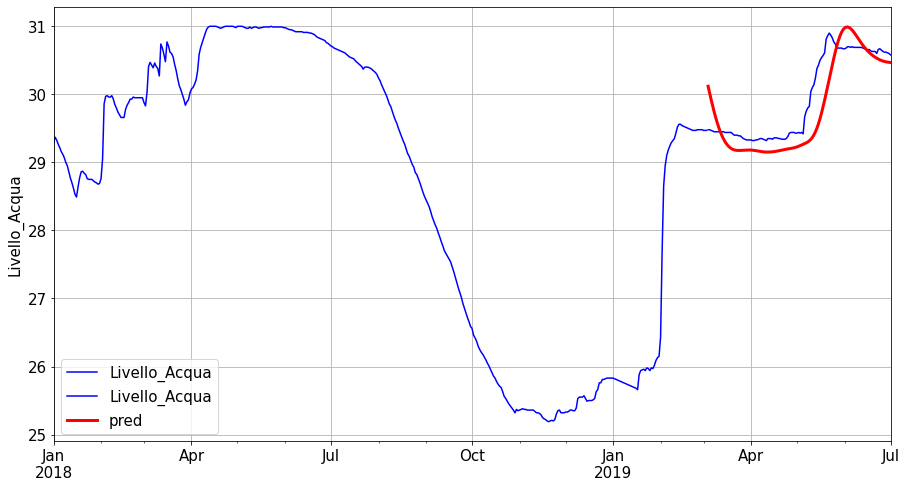

In [ ]:
# font = {'family' : 'normal',
#         'weight' : 'normal',
#         'size'   : 15}
# title=''
# ylabel='Livello_Acqua'
# xlabel='' 
# #final.columns = ['Livello_Acqua', 'pred']
# ax = final[final.index.year > 2017]['Livello_Acqua'].plot(legend=True,figsize=(15,8),title=title, color = 'blue')
# final['pred'].plot(legend=True, title=title, color ='red',linewidth=3)
# current_values = plt.gca().get_yticks()
# plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
# plt.rc('font', **font)
# ax.yaxis.grid(True)
# ax.xaxis.grid(True)
# ax.autoscale(axis='x',tight=True)
# ax.set(xlabel=xlabel, ylabel=ylabel);

# Traing Models target 2: Portata_Acqua

##1) SARIMAX 

In [9]:
train_PU_SA = pd.read_csv('/content/gdrive/MyDrive/Progetto_industry/Data/Prepared/train_PU_SA.csv')
train_PU_SA['Data'] = pd.to_datetime(train_PU_SA['Data'], format="%Y-%m-%d")
train_PU_SA.set_index('Data', inplace=True)

In [10]:
train_PU_SA.shape

(6013, 1)

In [11]:
auto=auto_arima(train_PU_SA)

In [12]:
auto.set_params

<bound method BaseEstimator.set_params of ARIMA(order=(2, 0, 2), scoring_args={}, suppress_warnings=True)>

Train SARIMA model for 'Portata Uscita w/o exogeneous variables


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:         Portata_Uscita   No. Observations:                 6013
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -13029.157
Date:                Wed, 24 Aug 2022   AIC                          26068.315
Time:                        14:33:59   BIC                          26101.823
Sample:                    01-06-2003   HQIC                         26079.950
                         - 06-23-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4551      0.010    139.774      0.000       1.435       1.476
ar.L2         -0.4628      0.010    -48.669      0.000      -0.481      -0.444
ma.L1         -0.4930      0.011    -44.947      0.0

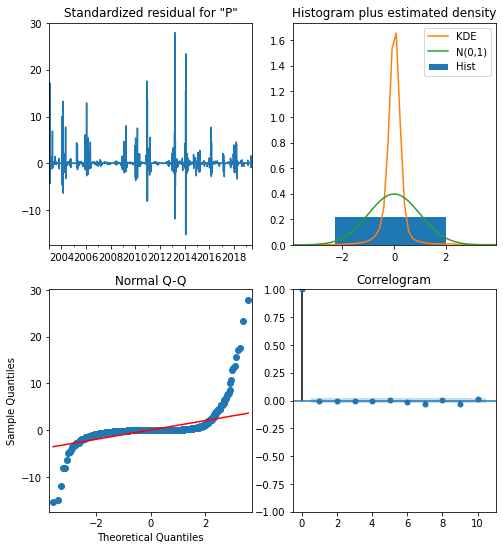


Diagnostics plots look almost normal
Irregularities might be due to the outliers


In [13]:
print(f"Train SARIMA model for 'Portata Uscita w/o exogeneous variables")

p_LT2 = 2
d_LT2 = 0
q_LT2 = 2
P_LT2 = 0
D_LT2 = 0
Q_LT2 = 0
s_LT2 = 12

model_SARIMA = SARIMAX(train_PU_SA, 
                       order=(p_LT2, d_LT2, q_LT2),
                       seasonal_order=(P_LT2, D_LT2, Q_LT2, s_LT2),
                       enforce_invertibility=False)

model_SARIMA_fit = model_SARIMA.fit(disp=0)
print(model_SARIMA_fit.summary())
print('')

print('Each term in the model is significant, P>|z| is less than 0.05')


model_SARIMA_fit.plot_diagnostics(figsize=(8,9))
plt.show();

print('')
print("Diagnostics plots look almost normal")
print("Irregularities might be due to the outliers")

In [14]:
#perform Durbin-Watson test
durbin_watson(model_SARIMA_fit.resid)

# The test statistic is 1.99. Since this is within the range of 1.5 and 2.5, 
# we would consider autocorrelation not to be problematic in this regression model.

1.9959141271328025

In [15]:
filename = '/content/gdrive/MyDrive/Progetto_industry/Models/model_arima_PU.pkl'
model_SARIMA_fit.save(filename, remove_data=False)

##2) XGBoost (Tentativo 1)

In [ ]:
train_PU_SL = pd.read_csv('/content/gdrive/MyDrive/Progetto_industry/Data/Prepared/train_PU_SL_T1.csv').drop('Unnamed: 0', axis=1)
train_PU_SL['Data'] = pd.to_datetime(train_PU_SL['Data'], format="%Y-%m-%d")
train_PU_SL.set_index('Data', inplace=True)
X = train_PU_SL.drop(['Target'],axis=1)
y = train_PU_SL['Target']

### 2.1) RandomizedSerachCV

In [ ]:
tscv = TimeSeriesSplit(n_splits=10)
estimator=XGBRegressor()
param_grid={'objective' :['reg:squarederror'],
            "learning_rate": (0.5,0.001 ,0.05, 0.15),
            'n_estimators': [150,200],
            'subsample': [0.7,0.9],
            "max_depth": [ 2,3, 4],
            "min_child_weight": [ 5, 7,10],
            "gamma":[ 0.01, 0.1, 0.2],
            "colsample_bytree":[ 0.3, 0.4],
            "booster" : ['gbtree', 'gblinear'],
            'random_state':[123],
            'seed': [456]}

In [ ]:
rsc = RandomizedSearchCV(estimator,param_grid, cv=tscv,scoring='neg_mean_absolute_error',verbose=1,n_jobs=-1, n_iter=10)

In [ ]:
rsc.fit(X,y)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
                   estimator=XGBRegressor(), n_jobs=-1,
                   param_distributions={'booster': ['gbtree', 'gblinear'],
                                        'colsample_bytree': [0.3, 0.4],
                                        'gamma': [0.01, 0.1, 0.2],
                                        'learning_rate': (0.5, 0.001, 0.05,
                                                          0.15),
                                        'max_depth': [2, 3, 4],
                                        'min_child_weight': [5, 7, 10],
                                        'n_estimators': [150, 200],
                                        'objective': ['reg:squarederror'],
                                        'random_state': [123], 'seed': [456],
                                        'subsample': [0.7, 0.9]},
                   scoring='neg_mean_absolute_error', verbose=1)

In [ ]:
rsc.best_params_

{'subsample': 0.7,
 'seed': 456,
 'random_state': 123,
 'objective': 'reg:squarederror',
 'n_estimators': 150,
 'min_child_weight': 10,
 'max_depth': 3,
 'learning_rate': 0.05,
 'gamma': 0.2,
 'colsample_bytree': 0.4,
 'booster': 'gbtree'}

###2.2) Feature Selection&Importance

In [ ]:
params=rsc.best_params_

<BarContainer object of 65 artists>

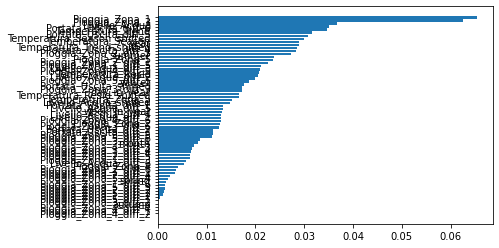

In [ ]:
model = XGBRegressor(**params)
model_fit = model.fit(X, y)
sorted_idx = model_fit.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], model_fit.feature_importances_[sorted_idx])

In [ ]:
estimator = XGBRegressor(**params)

In [ ]:
selector = RFECV(estimator, cv=tscv, scoring='neg_mean_squared_error')
selector = selector.fit(X, y)

In [ ]:
selector.ranking_

array([ 1,  1,  6,  1,  1,  1,  1,  8, 15,  1,  5,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, 10,  1,  1,  1,  4,  7, 13, 18, 17,  1,  1, 11, 12,
        1, 14,  2,  1,  1,  1,  1,  1, 16,  1,  1,  1,  9,  1,  1,  1,  1,
        1,  1,  3,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [ ]:
selector.n_features_

48

In [ ]:
selector.support_

array([ True,  True, False,  True,  True,  True,  True, False, False,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True, False, False,
       False, False, False,  True,  True, False, False,  True, False,
       False,  True,  True,  True,  True,  True, False,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


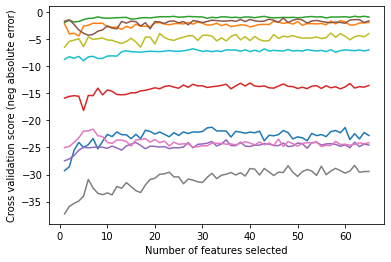

In [ ]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (neg absolute error)")
plt.plot(
    range(1, len(selector.grid_scores_) + 1),
    selector.grid_scores_,
)
plt.show();

###2.3) Tarining and Saving

In [ ]:
model = XGBRegressor(**params)
model_fit = model.fit(X, y)

In [ ]:
filename = '/content/gdrive/MyDrive/Progetto_industry/Models/XGB_model_PU_T1.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
cols = X.columns[selector.get_support()]

In [ ]:
X_new = X[cols]

In [ ]:
X_new.shape

(4527, 48)

In [ ]:
X_new.columns

Index(['Pioggia_Zona_1', 'Pioggia_Zona_2', 'Pioggia_Zona_4', 'Pioggia_Zona_5',
       'Temperatura_Zona_5', 'Livello_Acqua', 'summer', 'year', 'month',
       'day_in_year', 'week_in_year', 'Temperatura_Trend',
       'Temperatura_Season', 'Temperatura_Resid', 'Pioggia_Zona_1_diff_1',
       'Pioggia_Zona_2_diff_1', 'Pioggia_Zona_3_diff_1',
       'Pioggia_Zona_5_diff_1', 'Livello_Acqua_diff_1',
       'Portata_Uscita_diff_1', 'Livello_Acqua_diff_2',
       'Portata_Uscita_diff_2', 'Pioggia_Zona_3_diff_3',
       'Livello_Acqua_diff_3', 'Portata_Uscita_diff_3',
       'Pioggia_Zona_1_diff_4', 'Pioggia_Zona_2_diff_4',
       'Pioggia_Zona_3_diff_4', 'Pioggia_Zona_5_diff_4',
       'Livello_Acqua_diff_4', 'Portata_Uscita_diff_4',
       'Pioggia_Zona_2_diff_5', 'Pioggia_Zona_3_diff_5',
       'Pioggia_Zona_4_diff_5', 'Pioggia_Zona_5_diff_5',
       'Livello_Acqua_diff_5', 'Portata_Uscita_diff_5',
       'Pioggia_Zona_2_diff_6', 'Pioggia_Zona_3_diff_6',
       'Pioggia_Zona_4_diff_6', 'Pi

In [ ]:
model = XGBRegressor(**params)
model_fit = model.fit(X_new, y)

In [ ]:
filename = '/content/gdrive/MyDrive/Progetto_industry/Models/XGB_model_featsel_PU_T1.sav'
pickle.dump(model, open(filename, 'wb'))

##3) Random Forest (Tentativo 1)

In [ ]:
train_PU_SL = pd.read_csv('/content/gdrive/MyDrive/Progetto_industry/Data/Prepared/train_PU_SL_T1.csv').drop('Unnamed: 0', axis=1)
train_PU_SL['Data'] = pd.to_datetime(train_PU_SL['Data'], format="%Y-%m-%d")
train_PU_SL.set_index('Data', inplace=True)
X = train_PU_SL.drop(['Target'],axis=1)
y = train_PU_SL['Target']

### 3.1) RandomizedSerachCV

In [ ]:
estimator = RandomForestRegressor()
param_grid = { 
        "criterion":["squared_error", "absolute_error"],
        "n_estimators": [30,50,100],
        "max_features": ["auto"],
        "min_samples_split" : [2,4,8],
        "max_depth": [9,10],
        "min_samples_leaf":[2,3,4],
        'random_state' : [rng]
        }

In [ ]:
tscv = TimeSeriesSplit(n_splits=3)

In [ ]:
rsc = RandomizedSearchCV(estimator,param_grid, cv=tscv,scoring='neg_mean_absolute_error',verbose=1,n_jobs=-1, n_iter=3)

In [ ]:
rsc.fit(X,y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=RandomForestRegressor(), n_iter=3, n_jobs=-1,
                   param_distributions={'criterion': ['squared_error',
                                                      'absolute_error'],
                                        'max_depth': [9, 10],
                                        'max_features': ['auto'],
                                        'min_samples_leaf': [2, 3, 4],
                                        'min_samples_split': [2, 4, 8],
                                        'n_estimators': [30, 50, 100],
                                        'random_state': [RandomState(MT19937) at 0x7FB840EB3AF0]},
                   scoring='neg_mean_absolute_error', verbose=1)

In [ ]:
rsc.best_params_

{'random_state': RandomState(MT19937) at 0x7FB840EB3AF0,
 'n_estimators': 100,
 'min_samples_split': 4,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 10,
 'criterion': 'squared_error'}

###3.2) Feature Selection&Importance

In [ ]:
params=rsc.best_params_

<BarContainer object of 65 artists>

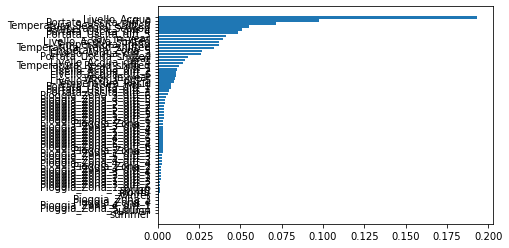

In [ ]:
model = RandomForestRegressor(**params)
model_fit = model.fit(X, y)
sorted_idx = model_fit.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], model_fit.feature_importances_[sorted_idx])

In [ ]:
estimator = RandomForestRegressor(**params)

In [ ]:
selector = RFECV(estimator, step=1, cv=tscv, scoring='neg_mean_squared_error')
selector = selector.fit(X, y)

In [ ]:
selector.ranking_

array([53, 46, 56, 29, 44,  6,  1, 59, 55, 60, 51, 14, 49,  1, 15,  1,  4,
       20, 34, 43, 58, 50, 57, 16, 22, 42, 40, 27, 54, 48, 10, 17, 41, 35,
       19, 45, 28,  3, 24, 26, 47, 30, 38, 18, 11,  2, 36, 25, 12, 32, 21,
       23,  5, 39, 52, 33, 37, 31, 13,  1,  7,  1,  9,  1,  8])

In [ ]:
selector.n_features_

6

In [ ]:
selector.support_   

array([False, False, False, False, False, False,  True, False, False,
       False, False, False, False,  True, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False,  True, False,
        True, False])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


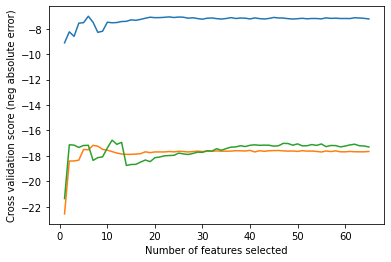

In [ ]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (neg absolute error)")
plt.plot(
    range(1, len(selector.grid_scores_) + 1),
    selector.grid_scores_,
)
plt.show();

###3.3) Training and Saving

In [ ]:
model = RandomForestRegressor(**params)
model_fit = model.fit(X, y)

In [ ]:
filename = '/content/gdrive/MyDrive/Progetto_industry/Models/RF_model_PU_T1.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
cols = X.columns[selector.get_support()]

In [ ]:
X_new = X[cols]

In [ ]:
X_new.shape

(4527, 6)

In [ ]:
X_new.columns

Index(['Livello_Acqua', 'day_in_year', 'Temperatura_Trend',
       'Portata_Uscita_diff_6', 'Temperatura_Season_shifted',
       'Livello_Acqua_shifted'],
      dtype='object')

In [ ]:
model = RandomForestRegressor(**params)
model_fit = model.fit(X_new, y)

In [ ]:
filename = '/content/gdrive/MyDrive/Progetto_industry/Models/RF_model_featsel_PU_T1.sav'
pickle.dump(model, open(filename, 'wb'))

##*4*) XGBoost (Tentativo 2)

In [ ]:
train_PU_SL = pd.read_csv('/content/gdrive/MyDrive/Progetto_industry/Data/Prepared/train_PU_SL_T2.csv')
train_PU_SL['Data'] = pd.to_datetime(train_PU_SL['Data'], format="%Y-%m-%d")
train_PU_SL.set_index('Data', inplace=True)
X = train_PU_SL.drop(['Target'],axis=1)
y = train_PU_SL['Target']

### 4.1) GridSerachCV

In [ ]:
tscv = TimeSeriesSplit(n_splits=10)
gsc = GridSearchCV(
            estimator=XGBRegressor(),
            param_grid={'objective' :['reg:squarederror'],
                        "learning_rate": (0.5,0.001 ,0.05, 0.15),
                        'n_estimators': [150,200],
                        'subsample': [0.7,0.9],
                        "max_depth": [ 2,3, 4],
                        "min_child_weight": [ 5, 7,10],
                        "gamma":[ 0.01, 0.1, 0.2],
                        "colsample_bytree":[ 0.3, 0.4],
                         "booster" : ['gbtree','gblinear'],
                        'random_state':[123],
                        'seed': [456]},
            cv=tscv, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1,)

In [ ]:
gsc.fit(X,y)

Fitting 10 folds for each of 1728 candidates, totalling 17280 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=XGBRegressor(), n_jobs=-1,
             param_grid={'booster': ['gbtree', 'gblinear'],
                         'colsample_bytree': [0.3, 0.4],
                         'gamma': [0.01, 0.1, 0.2],
                         'learning_rate': (0.5, 0.001, 0.05, 0.15),
                         'max_depth': [2, 3, 4], 'min_child_weight': [5, 7, 10],
                         'n_estimators': [150, 200],
                         'objective': ['reg:squarederror'],
                         'random_state': [123], 'seed': [456],
                         'subsample': [0.7, 0.9]},
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
gsc.best_params_

{'booster': 'gbtree',
 'colsample_bytree': 0.4,
 'gamma': 0.2,
 'learning_rate': 0.15,
 'max_depth': 2,
 'min_child_weight': 5,
 'n_estimators': 150,
 'objective': 'reg:squarederror',
 'random_state': 123,
 'seed': 456,
 'subsample': 0.7}

###4.2) Feature Selection&Importance

In [ ]:
params=gsc.best_params_

<BarContainer object of 13 artists>

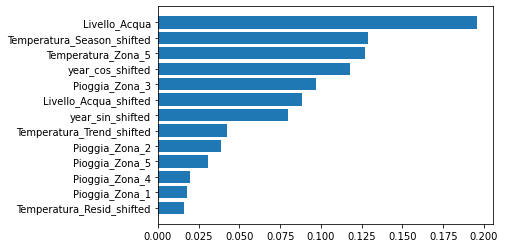

In [ ]:
model = XGBRegressor(**params)
model_fit = model.fit(X, y)
sorted_idx = model_fit.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], model_fit.feature_importances_[sorted_idx])

In [ ]:
estimator = XGBRegressor(**params)

In [ ]:
selector = RFECV(estimator, cv=tscv, scoring='neg_mean_squared_error')
selector = selector.fit(X, y)

In [ ]:
selector.ranking_

array([4, 1, 3, 1, 2, 1, 1, 1, 5, 1, 1, 1, 1])

In [ ]:
selector.n_features_

9

In [ ]:
selector.support_

array([False,  True, False,  True, False,  True,  True,  True, False,
        True,  True,  True,  True])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


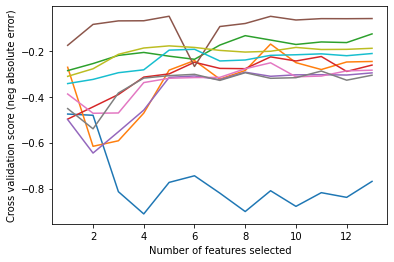

In [ ]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (neg absolute error)")
plt.plot(
    range(1, len(selector.grid_scores_) + 1),
    selector.grid_scores_,
)
plt.show();

###4.3) Training and Saving

In [ ]:
model = XGBRegressor(**params)
model_fit = model.fit(X, y)

In [ ]:
filename = '/content/gdrive/MyDrive/Progetto_industry/Models/XGB_model_PU_T2.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
cols = X.columns[selector.get_support()]

In [ ]:
X_new = X[cols]

In [ ]:
X_new.shape

(4622, 9)

In [ ]:
X_new.columns

Index(['Pioggia_Zona_2', 'Pioggia_Zona_4', 'Temperatura_Zona_5',
       'Temperatura_Trend_shifted', 'Temperatura_Season_shifted',
       'year_sin_shifted', 'year_cos_shifted', 'Livello_Acqua_shifted',
       'Livello_Acqua'],
      dtype='object')

In [ ]:
model = XGBRegressor(**params)
model_fit = model.fit(X_new, y)

In [ ]:
filename = '/content/gdrive/MyDrive/Progetto_industry/Models/XGB_model_featsel_PU_T2.sav'
pickle.dump(model, open(filename, 'wb'))

##5) Random Forest (Tentativo 2)

In [ ]:
train_PU_SL = pd.read_csv('/content/gdrive/MyDrive/Progetto_industry/Data/Prepared/train_PU_SL_T2.csv')
train_PU_SL['Data'] = pd.to_datetime(train_PU_SL['Data'], format="%Y-%m-%d")
train_PU_SL.set_index('Data', inplace=True)
X = train_PU_SL.drop(['Target'],axis=1)
y = train_PU_SL['Target']

### 5.1) GridSerachCV

In [ ]:
estimator = RandomForestRegressor()
param_grid = { 
        "criterion":["squared_error", "absolute_error"],
        "n_estimators": [30,50,100],
        "max_features": ["auto"],
        "min_samples_split" : [2,4,8],
        "max_depth": [9,10],
        "min_samples_leaf":[2,3,4],
        'random_state' : [rng]
        }

In [ ]:
tscv = TimeSeriesSplit(n_splits=3)

In [ ]:
rsc = RandomizedSearchCV(estimator,param_grid, cv=tscv,scoring='neg_mean_absolute_error',verbose=1,n_jobs=-1, n_iter=3)

In [ ]:
rsc.fit(X,y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=RandomForestRegressor(), n_iter=3, n_jobs=-1,
                   param_distributions={'criterion': ['squared_error',
                                                      'absolute_error'],
                                        'max_depth': [9, 10],
                                        'max_features': ['auto'],
                                        'min_samples_leaf': [2, 3, 4],
                                        'min_samples_split': [2, 4, 8],
                                        'n_estimators': [30, 50, 100],
                                        'random_state': [RandomState(MT19937) at 0x7FB840EB3AF0]},
                   scoring='neg_mean_absolute_error', verbose=1)

In [ ]:
rsc.best_params_

{'random_state': RandomState(MT19937) at 0x7FB840EB3AF0,
 'n_estimators': 50,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 9,
 'criterion': 'squared_error'}

###5.2) Feature Selection&Importance

In [ ]:
params=rsc.best_params_

<BarContainer object of 13 artists>

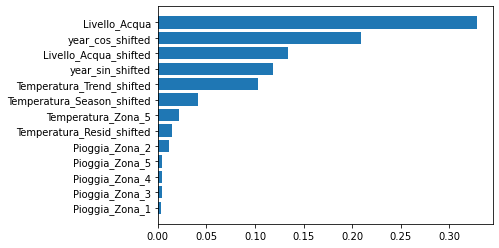

In [ ]:
model = RandomForestRegressor(**params)
model_fit = model.fit(X, y)
sorted_idx = model_fit.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], model_fit.feature_importances_[sorted_idx])

In [ ]:
estimator = RandomForestRegressor(**params)

In [ ]:
tscv = TimeSeriesSplit(n_splits=3)
selector = RFECV(estimator, step=1, cv=tscv, scoring='neg_mean_squared_error')
selector = selector.fit(X, y)

In [ ]:
selector.ranking_

array([10,  5,  8,  9,  7,  4,  1,  3,  6,  2,  1,  1,  1])

In [ ]:
selector.n_features_

4

In [ ]:
selector.support_

array([False, False, False, False, False, False,  True, False, False,
       False,  True,  True,  True])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


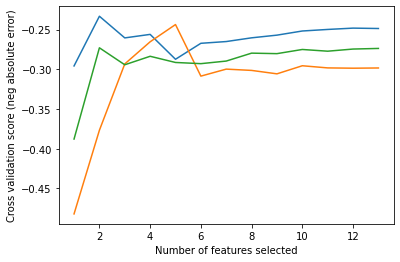

In [ ]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (neg absolute error)")
plt.plot(
    range(1, len(selector.grid_scores_) + 1),
    selector.grid_scores_,
)
plt.show();

###5.3) Training and Saving

In [ ]:
model = RandomForestRegressor(**params)
model_fit = model.fit(X, y)

In [ ]:
filename = '/content/gdrive/MyDrive/Progetto_industry/Models/RF_model_PU_T2.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
cols = X.columns[selector.get_support()]

In [ ]:
X_new = X[cols]

In [ ]:
X_new.shape

(4622, 4)

In [ ]:
X_new.columns

Index(['Temperatura_Trend_shifted', 'year_cos_shifted',
       'Livello_Acqua_shifted', 'Livello_Acqua'],
      dtype='object')

In [ ]:
model = RandomForestRegressor(**params)
model_fit = model.fit(X_new, y)

In [ ]:
filename = '/content/gdrive/MyDrive/Progetto_industry/Models/RF_model_featsel_PU_T2.sav'
pickle.dump(model, open(filename, 'wb'))